In [55]:
#Start
import os
import torch
import pandas as pd
import nltk
import json
from tqdm.auto import tqdm

from collections import Counter
import gc
import matplotlib.pyplot as plt


In [56]:
!curl -L -o /content/arxiv.zip https://www.kaggle.com/api/v1/datasets/download/Cornell-University/arxiv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1464M  100 1464M    0     0  21.7M      0  0:01:07  0:01:07 --:--:-- 22.0M


In [57]:
!unzip "/content/arxiv.zip"

Archive:  /content/arxiv.zip
replace arxiv-metadata-oai-snapshot.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [58]:
file_path = '/content/arxiv-metadata-oai-snapshot.json'

In [59]:
# Read the first 5 papers
papers = []
counter = 0
sample_size = 5

print(f"Loading {sample_size} papers from {file_path}...")

with open(file_path, 'r') as f:
    for line in f:
        try:
            paper = json.loads(line)
            papers.append(paper)
            counter += 1
            if counter >= sample_size:
                break
        except json.JSONDecodeError:
            print("Error parsing JSON line")
            continue

Loading 5 papers from /content/arxiv-metadata-oai-snapshot.json...


In [60]:

# Display the sample papers
for i, paper in enumerate(papers):
    print(f"\nPaper {i+1}:")
    for key, value in paper.items():
        # For complex fields, just show a summary
        if key == 'versions' or key == 'authors_parsed':
            print(f"{key}: [Complex data - length: {len(value)}]")
        else:
            # Truncate long values
            if isinstance(value, str) and len(value) > 100:
                print(f"{key}: {value[:100]}...")
            else:
                print(f"{key}: {value}")
    print('-' * 80)  # Separator



Paper 1:
id: 0704.0001
submitter: Pavel Nadolsky
authors: C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments: 37 pages, 15 figures; published version
journal-ref: Phys.Rev.D76:013009,2007
doi: 10.1103/PhysRevD.76.013009
report-no: ANL-HEP-PR-07-12
categories: hep-ph
license: None
abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the produ...
versions: [Complex data - length: 2]
update_date: 2008-11-26
authors_parsed: [Complex data - length: 4]
--------------------------------------------------------------------------------

Paper 2:
id: 0704.0002
submitter: Louis Theran
authors: Ileana Streinu and Louis Theran
title: Sparsity-certifying Graph Decompositions
comments: To appear in Graphs and Combinatorics
journal-ref: None
doi: None
report-no: None
categories: math.CO cs.CG
license: http://arxiv.org/licenses/nonexclusive-distrib/1

In [61]:
total_papers = 0
with open(file_path, 'r') as f:
    for _ in tqdm(f):
        total_papers += 1

0it [00:00, ?it/s]

In [62]:
print(f"Total number of papers in the dataset: {total_papers}")

Total number of papers in the dataset: 2720631


In [63]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [64]:
def tensor_histogram(data, bins=50):
    """Create histogram using PyTorch tensors for speed"""
    if len(data) > 0:
        tensor_data = torch.tensor(data, device=device)
        hist = torch.histc(tensor_data, bins=bins)
        bin_edges = torch.linspace(tensor_data.min().item(), tensor_data.max().item(), bins+1)
        return hist.cpu().numpy(), bin_edges.cpu().numpy()
    return None, None

In [65]:
# Initialize counters and collections for full dataset analysis
year_counts = Counter()
category_counts = Counter()
abstract_lengths = []
author_counts = []
total_papers = 0
ai_papers_by_year = Counter()

In [66]:
# Process in chunks to manage memory
chunk_size = 100000  # Process 100k papers at a time
file_path = '/content/arxiv-metadata-oai-snapshot.json'

In [67]:
print(f"Analyzing all 2.7 million papers from {file_path} using PyTorch optimizations...")
print("This may take some time but will provide the most accurate analysis.")

Analyzing all 2.7 million papers from /content/arxiv-metadata-oai-snapshot.json using PyTorch optimizations...
This may take some time but will provide the most accurate analysis.


In [68]:
with open(file_path, 'r') as f:
    for line in tqdm(f, total=2720631):  # Use the exact count you found
        try:
            paper = json.loads(line)

            # Extract year
            year = paper.get('update_date', '').split('-')[0] if paper.get('update_date') else None
            if year and year.isdigit():
                year_counts[year] += 1

            # Extract primary category
            categories = paper.get('categories', '')
            if categories:
                primary_category = categories.split(' ')[0]
                category_counts[primary_category] += 1

            # Abstract length
            abstract = paper.get('abstract', '')
            if abstract:
                # Sample abstract lengths (to avoid storing too many values)
                if total_papers % 10 == 0:  # Sample every 10th paper
                    abstract_lengths.append(len(abstract.split()))

            # Author count
            authors_parsed = paper.get('authors_parsed', [])
            if authors_parsed:
                # Sample author counts
                if total_papers % 10 == 0:  # Sample every 10th paper
                    author_counts.append(len(authors_parsed))

            # Check for AI papers
            if categories and 'cs.AI' in categories:
                if year and year.isdigit():
                    ai_papers_by_year[year] += 1

            total_papers += 1

            # Periodically clear memory
            if total_papers % chunk_size == 0:
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()  # Clear CUDA cache
                print(f"Processed {total_papers:,} papers...")

        except json.JSONDecodeError:
            continue
        except Exception as e:
            print(f"Error processing paper: {e}")
            continue

print(f"Completed analysis of {total_papers:,} papers")

  0%|          | 0/2720631 [00:00<?, ?it/s]

Processed 100,000 papers...
Processed 200,000 papers...
Processed 300,000 papers...
Processed 400,000 papers...
Processed 500,000 papers...
Processed 600,000 papers...
Processed 700,000 papers...
Processed 800,000 papers...
Processed 900,000 papers...
Processed 1,000,000 papers...
Processed 1,100,000 papers...
Processed 1,200,000 papers...
Processed 1,300,000 papers...
Processed 1,400,000 papers...
Processed 1,500,000 papers...
Processed 1,600,000 papers...
Processed 1,700,000 papers...
Processed 1,800,000 papers...
Processed 1,900,000 papers...
Processed 2,000,000 papers...
Processed 2,100,000 papers...
Processed 2,200,000 papers...
Processed 2,300,000 papers...
Processed 2,400,000 papers...
Processed 2,500,000 papers...
Processed 2,600,000 papers...
Processed 2,700,000 papers...
Completed analysis of 2,720,631 papers


In [13]:
# Convert to Series for easier plotting
year_series = pd.Series(year_counts).sort_index()
category_series = pd.Series(category_counts)

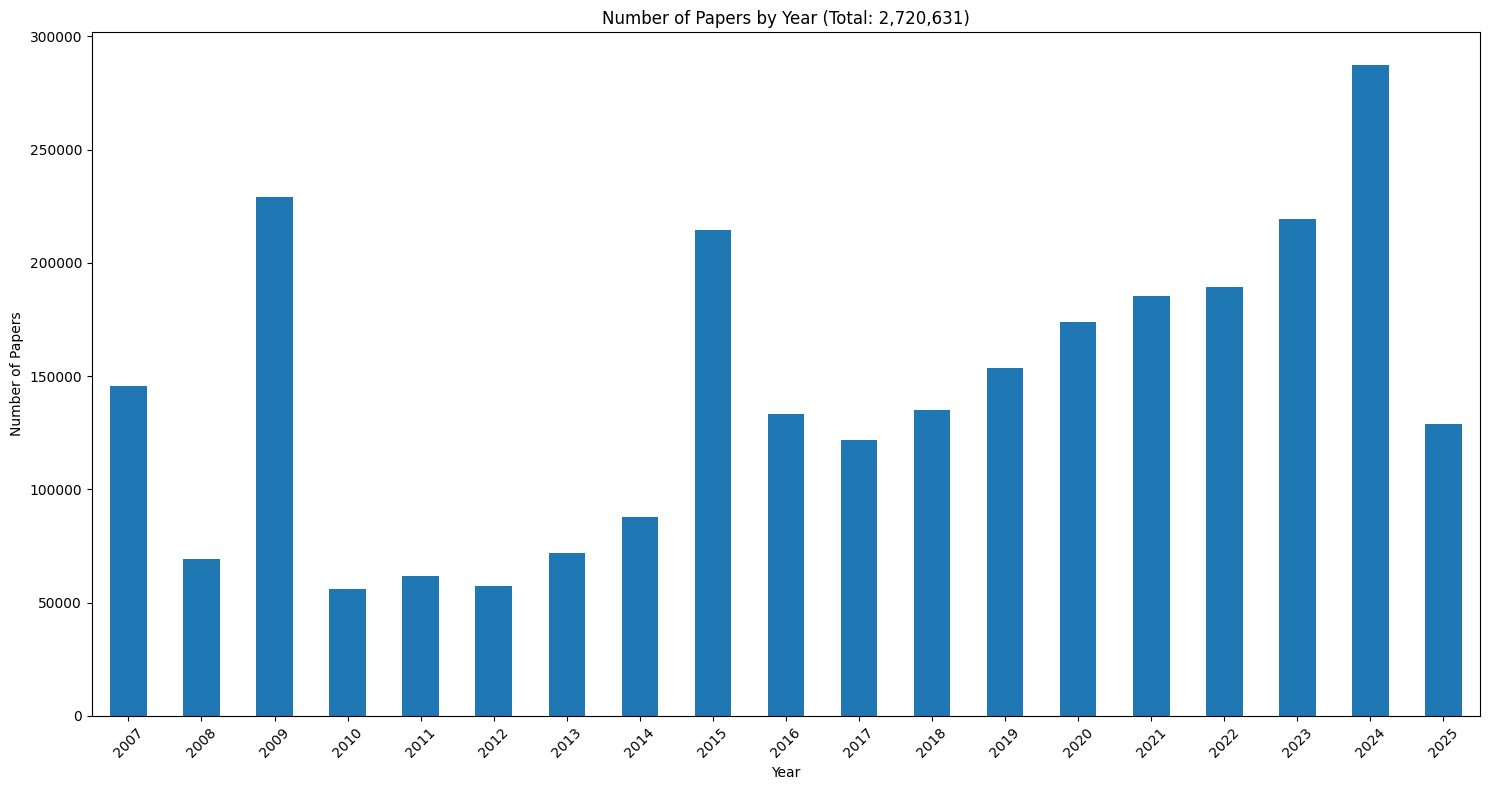

In [16]:
# Create visualizations
plt.figure(figsize=(15, 8))
year_series.plot(kind='bar')
plt.title(f'Number of Papers by Year (Total: {total_papers:,})')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('papers_by_year_full.png')
plt.show()

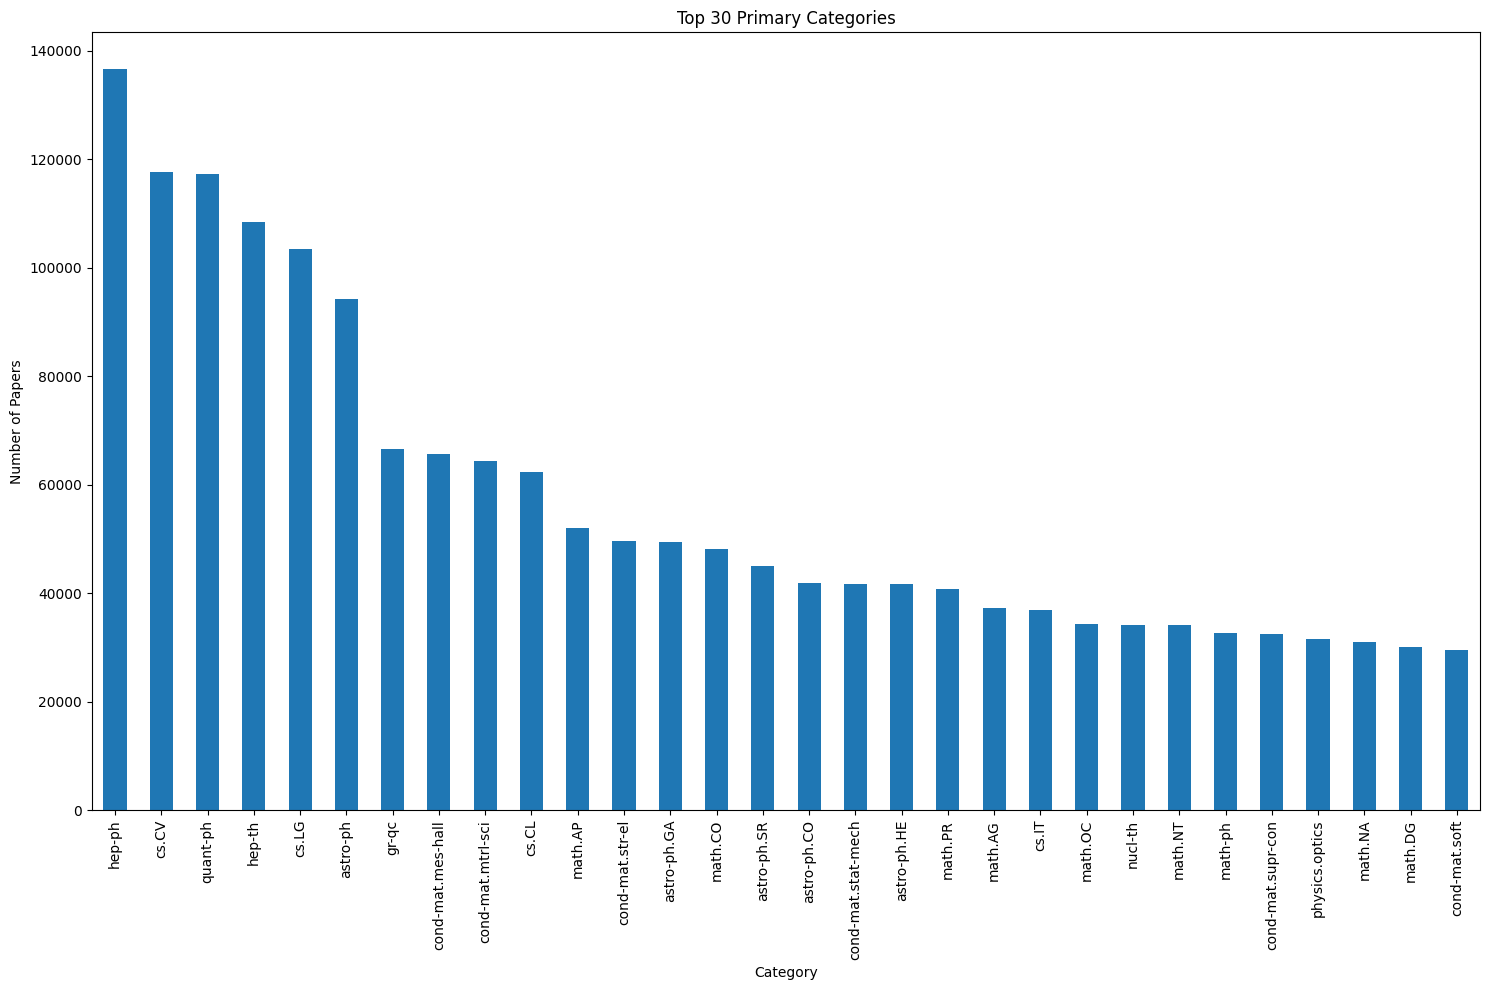

In [17]:
plt.figure(figsize=(15, 10))
category_series.sort_values(ascending=False).head(30).plot(kind='bar')
plt.title('Top 30 Primary Categories')
plt.xlabel('Category')
plt.ylabel('Number of Papers')
plt.tight_layout()
plt.savefig('papers_by_category_full.png')
plt.show()


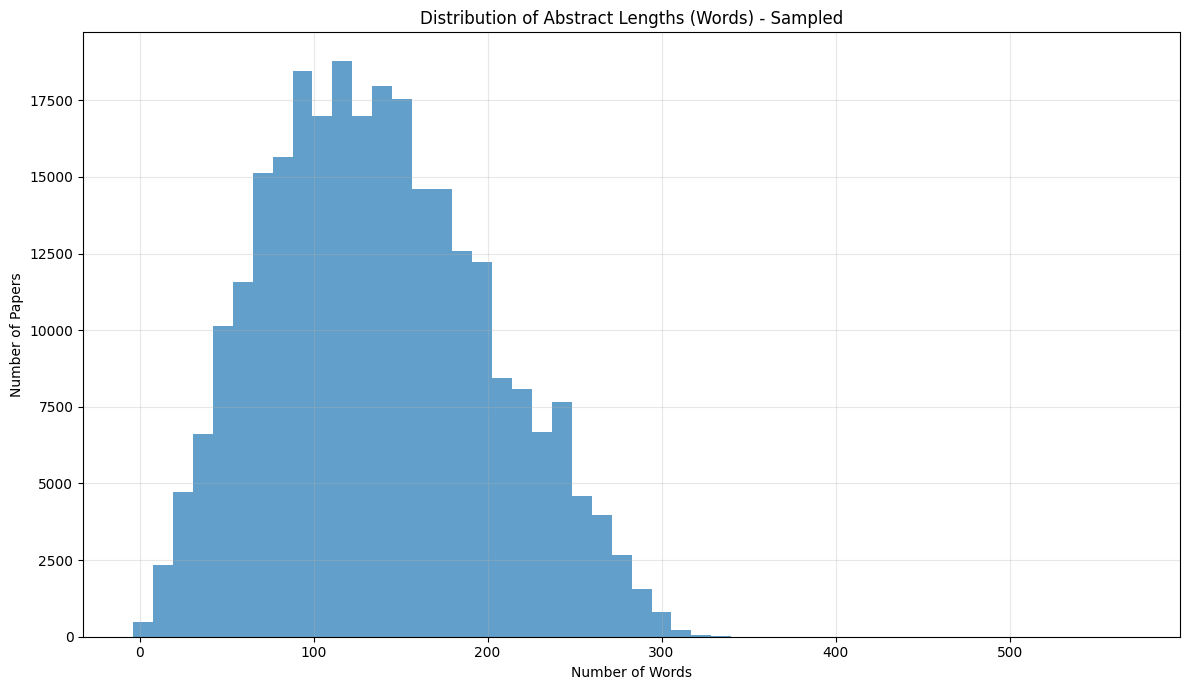

In [18]:
# Use tensor-based histogram for abstract lengths
plt.figure(figsize=(12, 7))
hist_data, bin_edges = tensor_histogram(abstract_lengths, bins=50)
if hist_data is not None:
    plt.bar(bin_edges[:-1], hist_data, width=(bin_edges[1]-bin_edges[0]), alpha=0.7)
    plt.title('Distribution of Abstract Lengths (Words) - Sampled')
    plt.xlabel('Number of Words')
    plt.ylabel('Number of Papers')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('abstract_length_dist_full.png')
    plt.show()

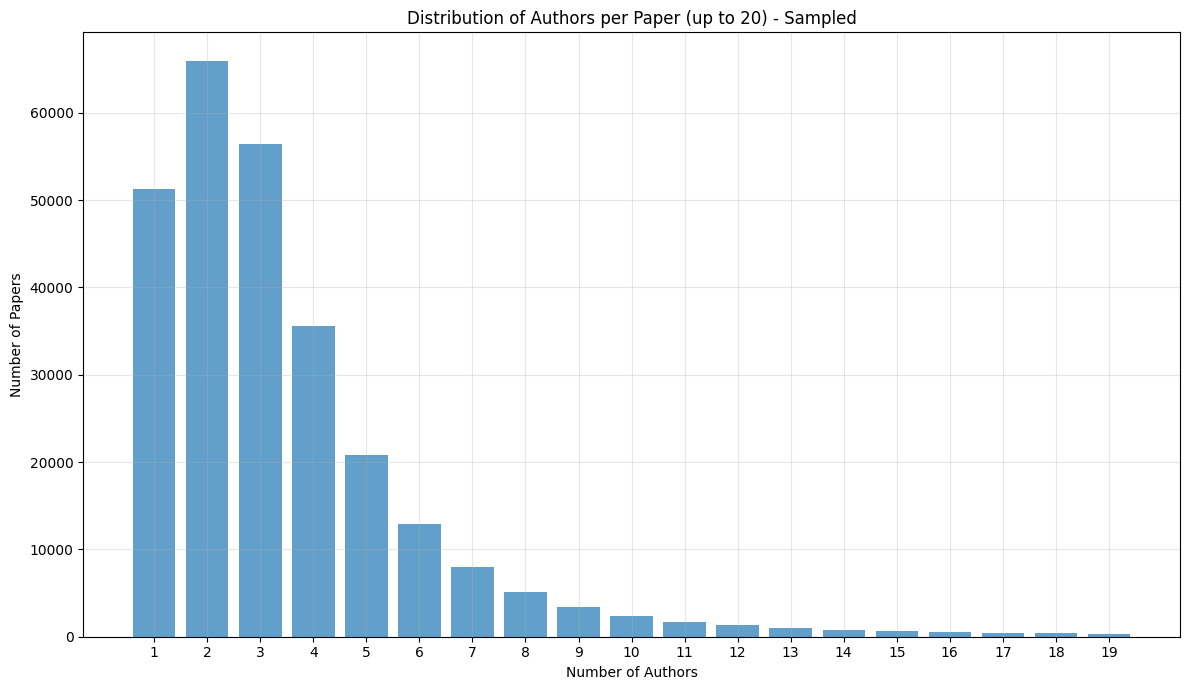

In [19]:
# Use tensor-based histogram for author counts
plt.figure(figsize=(12, 7))
author_counts_filtered = [count for count in author_counts if count < 20]  # Filter to reasonable range
hist_data, bin_edges = tensor_histogram(author_counts_filtered, bins=19)
if hist_data is not None:
    plt.bar(range(1, 20), hist_data, alpha=0.7)
    plt.title('Distribution of Authors per Paper (up to 20) - Sampled')
    plt.xlabel('Number of Authors')
    plt.ylabel('Number of Papers')
    plt.xticks(range(1, 20))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('authors_per_paper_full.png')
    plt.show()

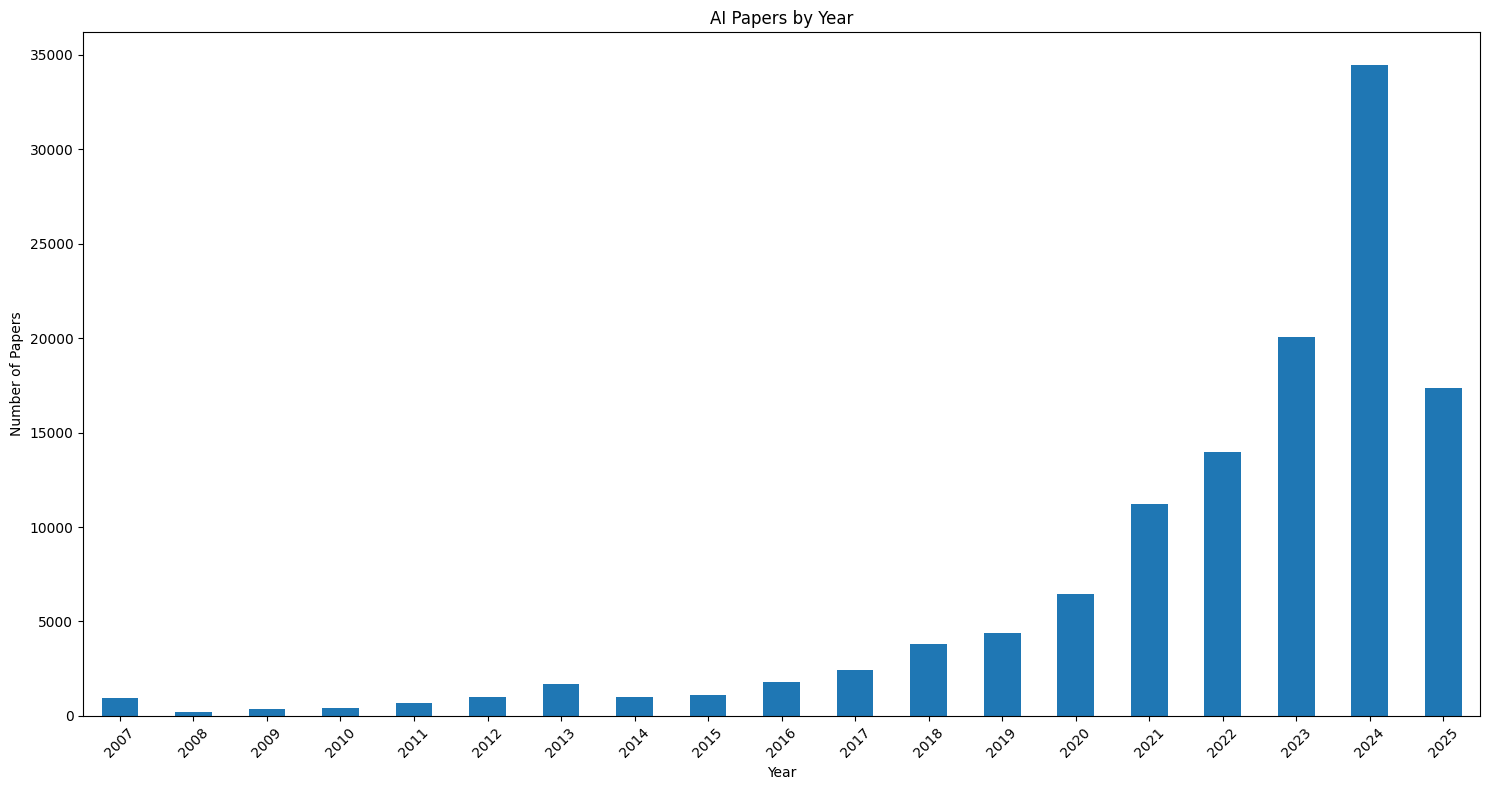

In [20]:
# AI papers analysis
ai_year_series = pd.Series(ai_papers_by_year).sort_index()
plt.figure(figsize=(15, 8))
ai_year_series.plot(kind='bar')
plt.title('AI Papers by Year')
plt.xlabel('Year')
plt.ylabel('Number of Papers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('ai_papers_by_year_full.png')
plt.show()

In [21]:
# Print some statistics
print(f"Total papers analyzed: {total_papers:,}")
print(f"Total AI papers: {sum(ai_papers_by_year.values()):,}")
print(f"Year range: {min(year_counts.keys())} - {max(year_counts.keys())}")
print(f"Top 10 categories:")
for category, count in category_series.sort_values(ascending=False).head(10).items():
    print(f"  {category}: {count:,} papers")

Total papers analyzed: 2,720,631
Total AI papers: 123,501
Year range: 2007 - 2025
Top 10 categories:
  hep-ph: 136,523 papers
  cs.CV: 117,630 papers
  quant-ph: 117,195 papers
  hep-th: 108,381 papers
  cs.LG: 103,324 papers
  astro-ph: 94,246 papers
  gr-qc: 66,496 papers
  cond-mat.mes-hall: 65,610 papers
  cond-mat.mtrl-sci: 64,410 papers
  cs.CL: 62,325 papers


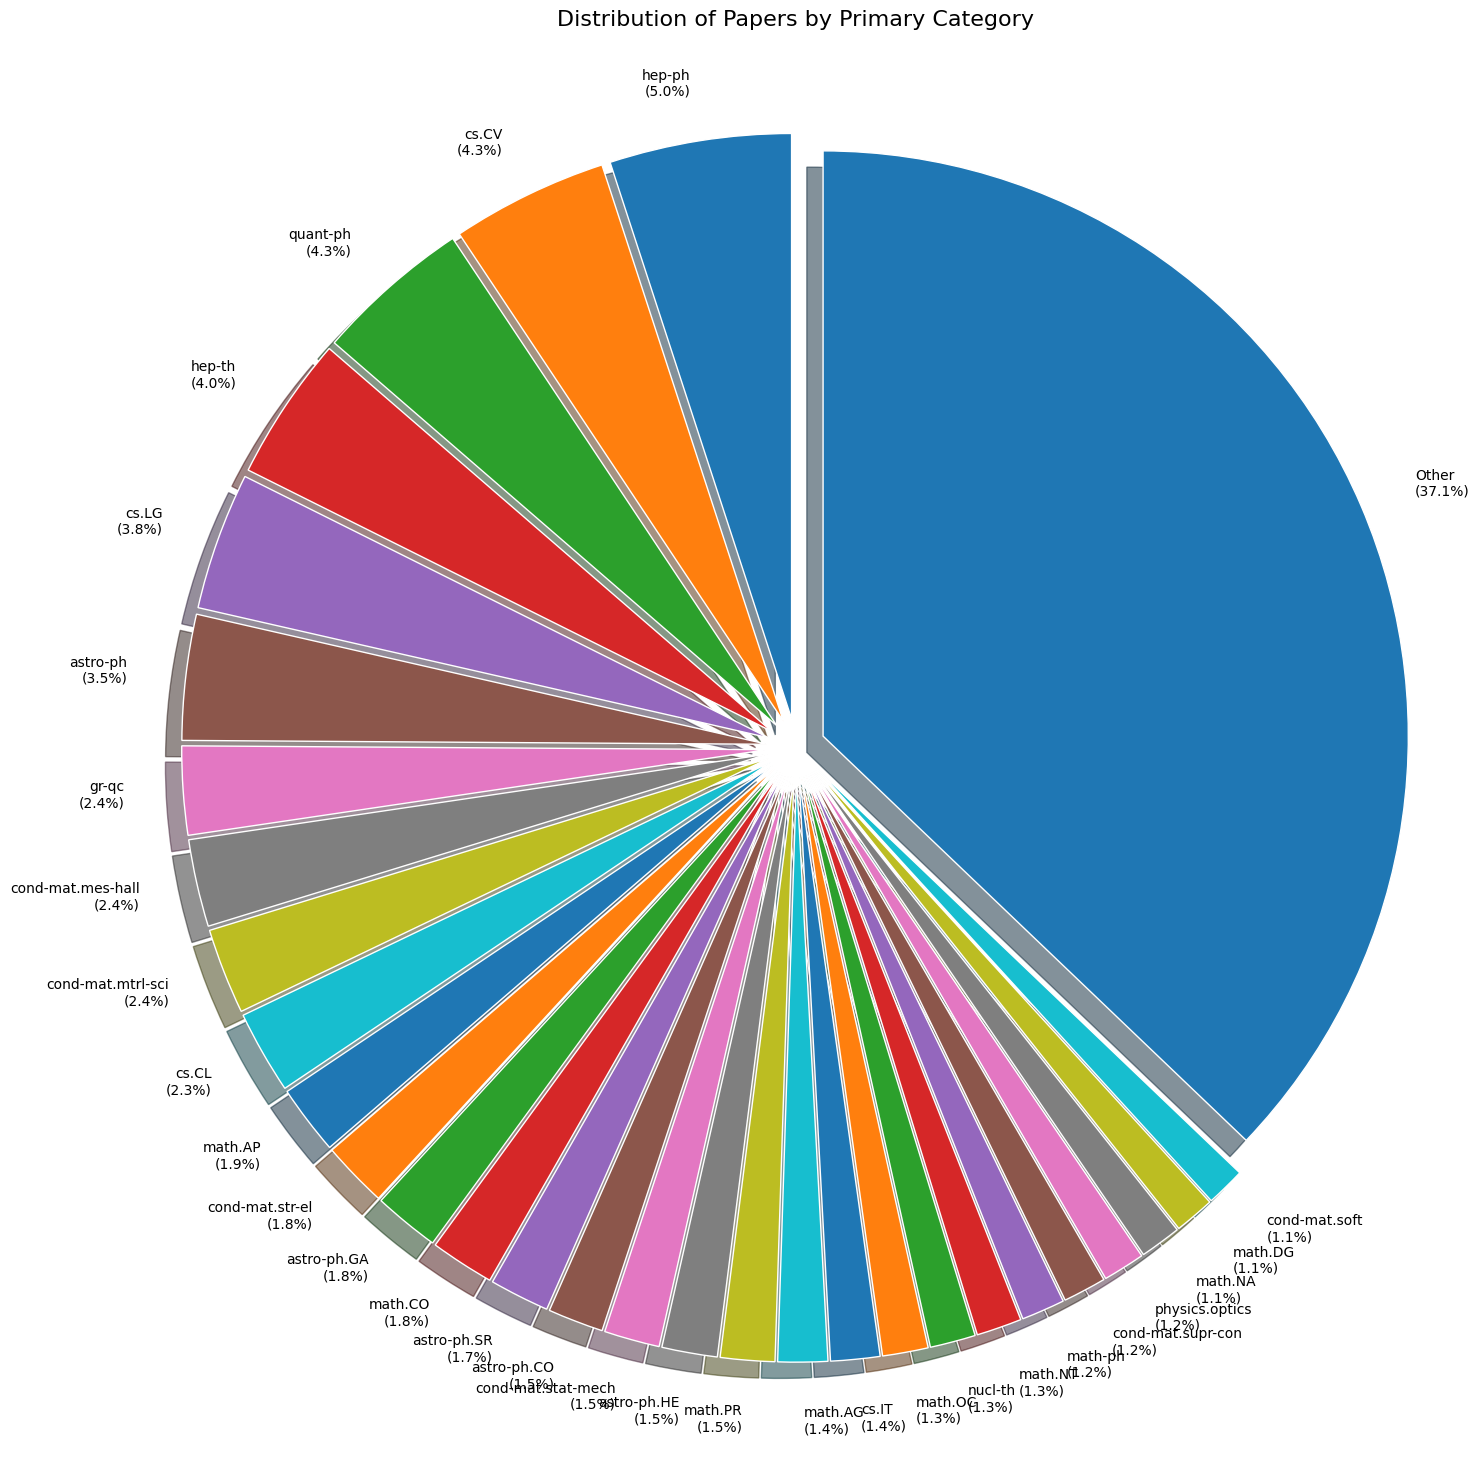

In [22]:
# Create a pie chart for category distribution
plt.figure(figsize=(15, 15))

# Get top categories (top 10 for readability) and combine the rest
top_categories = category_series.sort_values(ascending=False)
top_n = 30  # Number of categories to show individually
other_count = top_categories[top_n:].sum()

# Create a new series with top categories and "Other"
pie_data = top_categories[:top_n].copy()
pie_data['Other'] = other_count

# Calculate percentages
total = pie_data.sum()
percentages = pie_data / total * 100

# Create labels with percentages
labels = [f"{category}\n({percent:.1f}%)" for category, percent in zip(pie_data.index, percentages)]

# Create pie chart
plt.pie(pie_data, labels=labels, autopct='', startangle=90, shadow=True,
        explode=[0.05] * len(pie_data), wedgeprops={'edgecolor': 'white', 'linewidth': 1})

plt.title('Distribution of Papers by Primary Category', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.savefig('category_pie_chart.png')
plt.show()

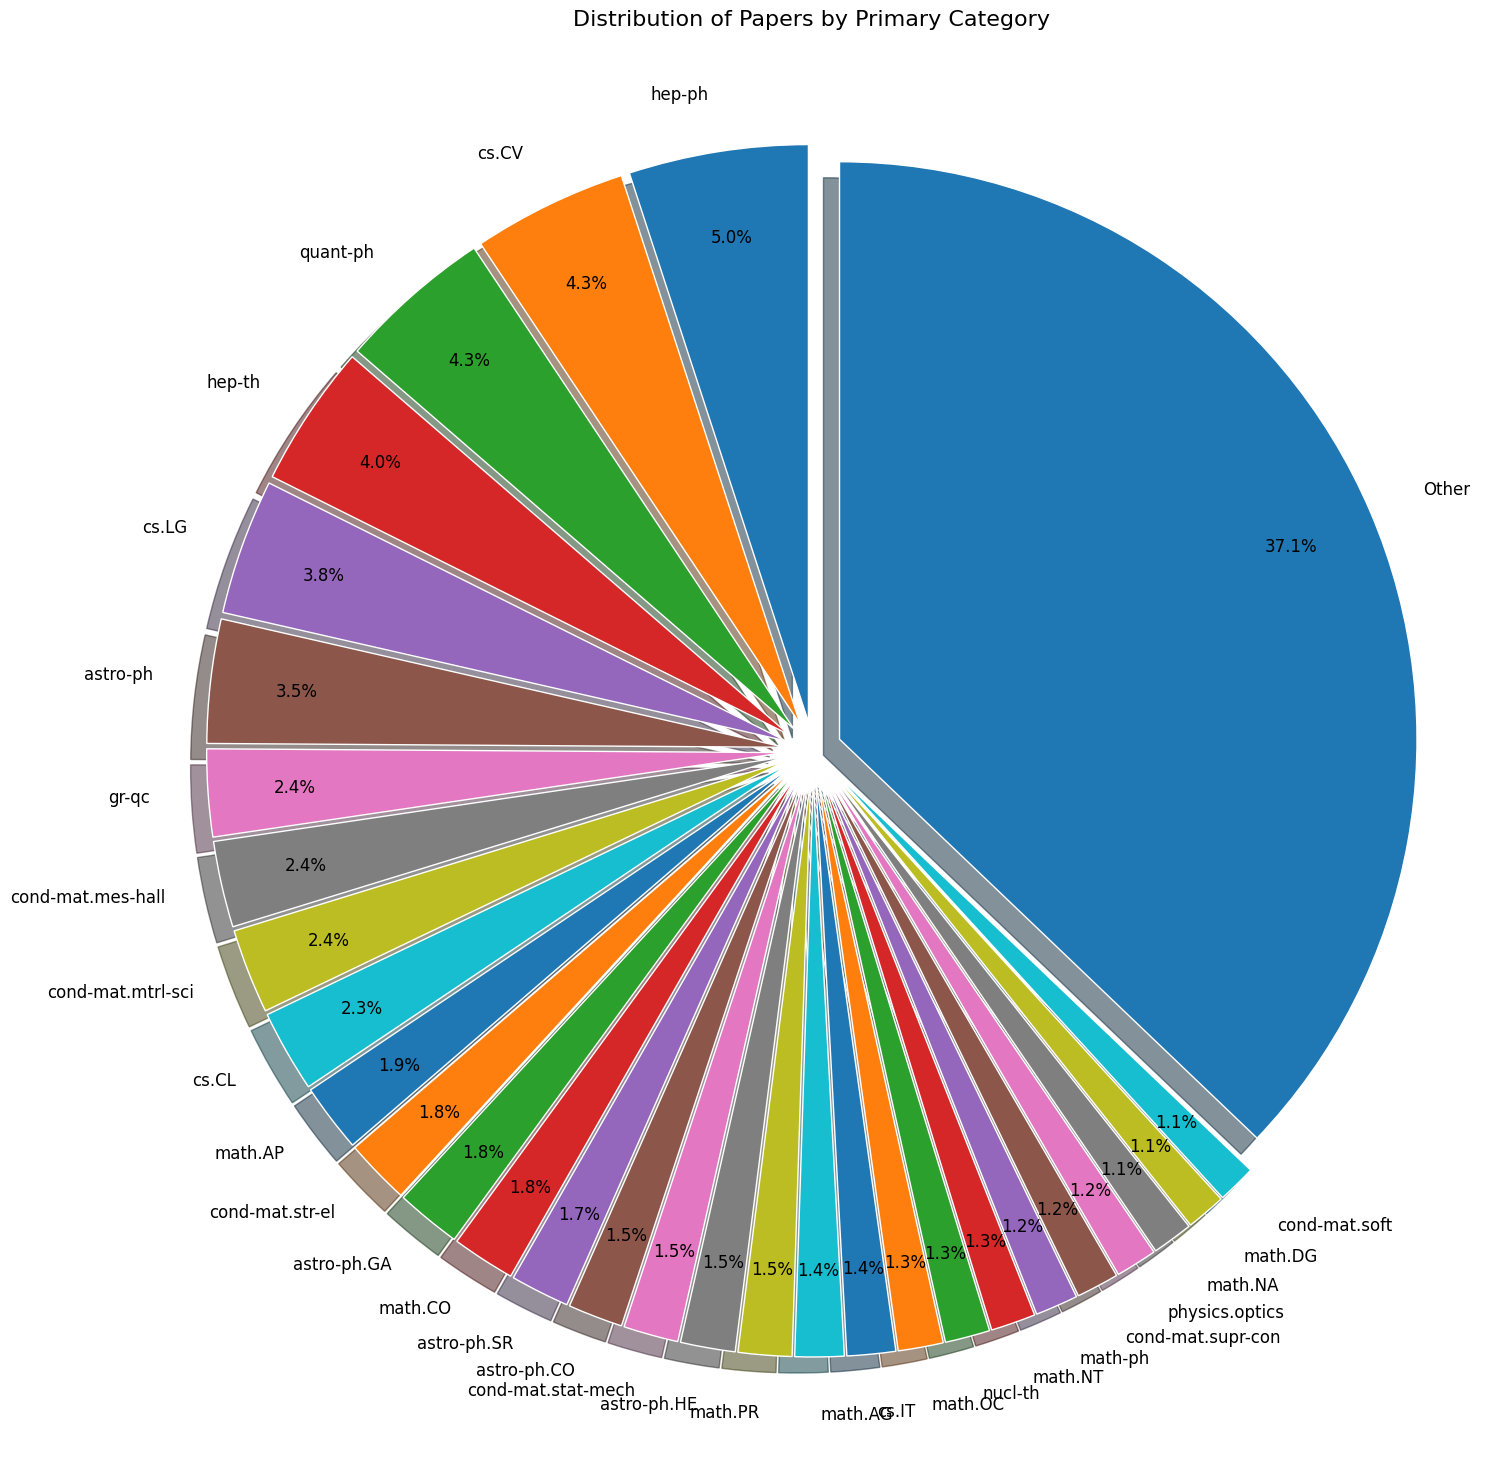

In [23]:
# Create a pie chart for category distribution with percentages at inner edge
plt.figure(figsize=(15, 15))

# Get top categories (top 10 for readability) and combine the rest
top_categories = category_series.sort_values(ascending=False)
top_n = 30  # Number of categories to show individually
other_count = top_categories[top_n:].sum()

# Create a new series with top categories and "Other"
pie_data = top_categories[:top_n].copy()
pie_data['Other'] = other_count

# Calculate percentages
total = pie_data.sum()
percentages = pie_data / total * 100

# Create labels with category names only (percentages will be inside)
labels = pie_data.index

# Create pie chart with custom autopct function to place text at inner radius
def make_autopct(values):
    def my_autopct(pct):
        # Only show percentages above 1%
        return f'{pct:.1f}%' if pct > 1 else ''
    return my_autopct

# Create pie chart with percentages inside at inner edge
plt.pie(pie_data, labels=labels,
        autopct=make_autopct(percentages),
        pctdistance=0.85,  # Position percentage labels closer to center (inner edge)
        startangle=90,
        shadow=True,
        explode=[0.05] * len(pie_data),
        wedgeprops={'edgecolor': 'white', 'linewidth': 1},
        textprops={'fontsize': 12})

plt.title('Distribution of Papers by Primary Category', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.savefig('category_pie_chart.png')
plt.show()

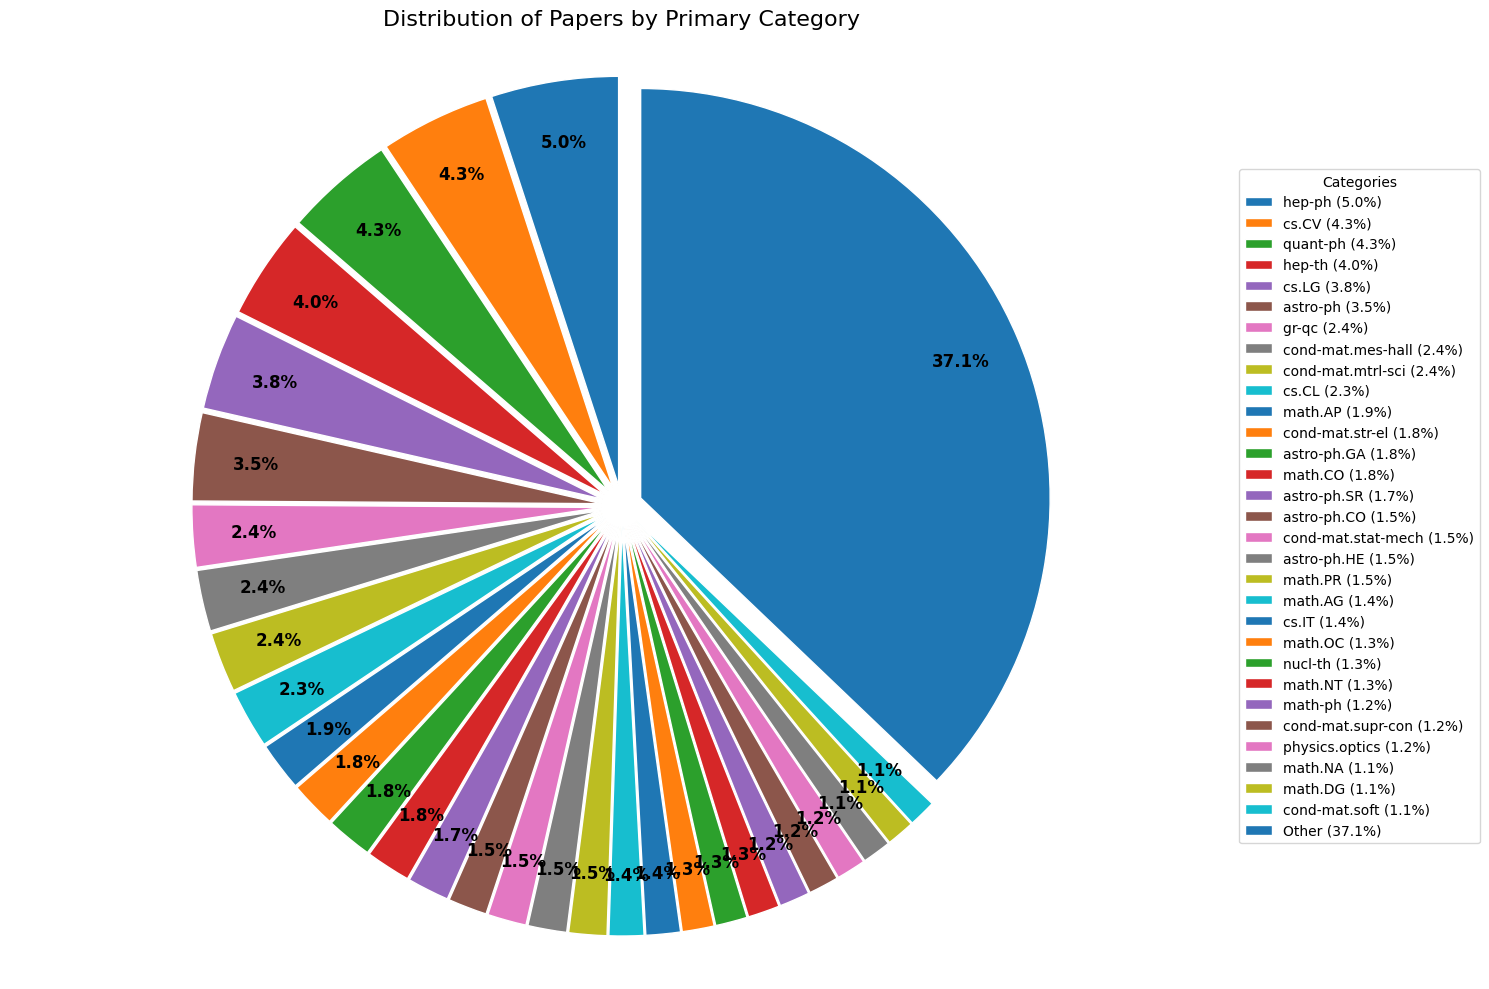

In [24]:
# Create a pie chart with a separate legend instead of labels on the chart
plt.figure(figsize=(15, 10))

# Get top categories and combine the rest
top_categories = category_series.sort_values(ascending=False)
top_n = 30  # Number of categories to show individually
other_count = top_categories[top_n:].sum()

# Create a new series with top categories and "Other"
pie_data = top_categories[:top_n].copy()
pie_data['Other'] = other_count

# Calculate percentages
total = pie_data.sum()
percentages = pie_data / total * 100

# Create the pie chart without labels on the chart
wedges, texts, autotexts = plt.pie(
    pie_data,
    autopct='%1.1f%%',
    pctdistance=0.85,  # Position percentage labels closer to center
    startangle=90,
    explode=[0.05] * len(pie_data),
    wedgeprops={'edgecolor': 'white', 'linewidth': 1},
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

# Hide the labels on the pie chart (we'll use a legend instead)
for text in texts:
    text.set_visible(False)

# Create a legend with percentages
legend_labels = [f"{cat} ({pct:.1f}%)" for cat, pct in zip(pie_data.index, percentages)]
plt.legend(wedges, legend_labels, title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Distribution of Papers by Primary Category', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.savefig('category_pie_chart_with_legend.png')
plt.show()

In [25]:

# Print exact percentages for reference
print("Category Distribution (%):")
for category, percent in zip(pie_data.index, percentages):
    print(f"{category}: {percent:.2f}%")

Category Distribution (%):
hep-ph: 5.02%
cs.CV: 4.32%
quant-ph: 4.31%
hep-th: 3.98%
cs.LG: 3.80%
astro-ph: 3.46%
gr-qc: 2.44%
cond-mat.mes-hall: 2.41%
cond-mat.mtrl-sci: 2.37%
cs.CL: 2.29%
math.AP: 1.91%
cond-mat.str-el: 1.83%
astro-ph.GA: 1.82%
math.CO: 1.77%
astro-ph.SR: 1.65%
astro-ph.CO: 1.54%
cond-mat.stat-mech: 1.53%
astro-ph.HE: 1.53%
math.PR: 1.50%
math.AG: 1.37%
cs.IT: 1.36%
math.OC: 1.26%
nucl-th: 1.26%
math.NT: 1.25%
math-ph: 1.20%
cond-mat.supr-con: 1.19%
physics.optics: 1.16%
math.NA: 1.14%
math.DG: 1.11%
cond-mat.soft: 1.08%
Other: 37.14%


In [69]:
year_counts

Counter({'2008': 69266,
         '2007': 145731,
         '2013': 71749,
         '2015': 214419,
         '2009': 228935,
         '2010': 56129,
         '2014': 87730,
         '2022': 189300,
         '2011': 61742,
         '2012': 57159,
         '2016': 133058,
         '2021': 185399,
         '2019': 153524,
         '2023': 219432,
         '2017': 121870,
         '2024': 287390,
         '2020': 173696,
         '2018': 135128,
         '2025': 128974})

In [70]:
category_counts

Counter({'hep-ph': 136523,
         'math.CO': 48069,
         'physics.gen-ph': 9200,
         'math.CA': 15697,
         'cond-mat.mes-hall': 65610,
         'gr-qc': 66496,
         'cond-mat.mtrl-sci': 64410,
         'astro-ph': 94246,
         'math.NT': 34057,
         'hep-th': 108381,
         'math.PR': 40782,
         'hep-ex': 23867,
         'nlin.PS': 4457,
         'math.NA': 31000,
         'cond-mat.str-el': 49685,
         'math.RA': 11275,
         'physics.optics': 31489,
         'q-bio.PE': 7583,
         'q-bio.QM': 5375,
         'math.OA': 8301,
         'math.QA': 9190,
         'cond-mat.stat-mech': 41742,
         'quant-ph': 117195,
         'cs.NE': 7289,
         'physics.ed-ph': 3266,
         'math.DG': 30114,
         'cond-mat.soft': 29509,
         'physics.pop-ph': 1374,
         'nucl-th': 34200,
         'math.FA': 20881,
         'cs.DS': 16429,
         'math.AG': 37292,
         'math.DS': 23750,
         'physics.soc-ph': 13118,
         'math